In [1]:
data_dir = '/home/ubuntu/data/iceberg'

import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation
from keras.layers.merge import Add, Concatenate
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import cv2
import keras
import os
from keras.callbacks import TensorBoard

from keras import __version__
print(__version__)


Using TensorFlow backend.


2.1.1


In [2]:
np.random.seed(1234)

def get_scaled_imgs(df):
    imgs = []

    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)

        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

#         imgs.append(np.dstack((band_1, band_2, band_3)))
        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [26]:
df_train = pd.read_json(os.path.join(data_dir, 'train.json'))
Xtrain = get_scaled_imgs(df_train)
Ytrain = np.array(df_train['is_iceberg'])
ids = np.array(df_train['id'])

df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle>0)

Ytrain = Ytrain[idx_tr[0]]
ids = ids[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]
Xinc = df_train.inc_angle[idx_tr[0]]

In [27]:
ids.shape, Ytrain.shape

((1471,), (1471,))

In [28]:
# Create a train and validation split, 75% of data used in training
from sklearn.model_selection import train_test_split

X_train, X_valid, X_inc_train, X_inc_valid, Y_train, Y_valid, train_ids, valid_ids = train_test_split(Xtrain,
                                    Xinc, Ytrain, ids, random_state=666, train_size=0.9, test_size=0.1)

X_train.shape, X_valid.shape, X_inc_train.shape, X_inc_valid.shape, Y_train.shape, Y_valid.shape, train_ids.shape, valid_ids.shape

((1323, 75, 75, 3),
 (148, 75, 75, 3),
 (1323,),
 (148,),
 (1323,),
 (148,),
 (1323,),
 (148,))

In [29]:
p = 0.2
input_shape = (75, 75, 3)
num_classes = 2

classifier_input = Input(shape=input_shape)
inc_angle_input = Input(shape=(1,))

# CNN 1
x = Conv2D(64, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Dropout(p)(x)

# CNN 2
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Dropout(p)(x)

# CNN 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Dropout(p)(x)

# CNN 3
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Dropout(p)(x)

# x = BatchNormalization(axis=-1)(x)

# CNN 4
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
# x = BatchNormalization(axis=-1)(x)
x = Dropout(p)(x)

x = Flatten()(x)

# x = GlobalAveragePooling2D()(x)
m = Concatenate()([inc_angle_input, x])
m = Dense(512, activation='relu')(m)
m = Dense(256, activation='relu')(m)
out = Dense(2, activation='sigmoid')(m)
# out = Activation('softmax')(m)

# optimizer = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer = Adam(lr=0.0015, decay=0.0)
model2 = Model(inputs=[classifier_input, inc_angle_input], outputs=out)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model2.load_weights('/home/ubuntu/data/iceberg/results/weights/norm_image_inc_angle-Copy1_model2_96_acc.h5')

In [31]:
batch_size = 256
        
tbCallBack = TensorBoard(log_dir='/home/ubuntu/data/tensorboardlogs/', histogram_freq=0, write_graph=True, write_images=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, epsilon=1e-4, mode='min')

In [32]:
model2.fit([X_train, X_inc_train], to_categorical(Y_train),
                                          batch_size=128, 
                                          epochs=3,
                                          validation_data=([X_valid, X_inc_valid], to_categorical(Y_valid)),
                                          shuffle=True, 
                                          callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tbCallBack])

Train on 1323 samples, validate on 148 samples
Epoch 1/3
1323/1323 [==============================] - 3s 2ms/step - loss: 0.0978 - acc: 0.9652 - val_loss: 0.2111 - val_acc: 0.9122
Epoch 2/3
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0492 - acc: 0.9826 - val_loss: 0.1959 - val_acc: 0.9392
Epoch 3/3
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0298 - acc: 0.9887 - val_loss: 0.1865 - val_acc: 0.9595


In [33]:
pred_valid = model2.predict([X_valid,X_inc_valid])

In [34]:
# Y_valid = np.expand_dims(Y_valid, axis=1)
np.squeeze(Y_valid).shape

(148,)

In [47]:
data.shape, valid_ids.shape

((148, 4), (148,))

In [36]:
df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])

In [37]:
df.value1 = valid_ids

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_img_set(img_num):
    # randomly needs the squeeze false parameter if you only want one row of images
    f,ax = plt.subplots(1,3,figsize=(20,10), squeeze=False)
    ax[0][0].imshow(X_valid[img_num, :, :,0]), ax[0][0].set_title("band 1")
    ax[0][1].imshow(X_valid[img_num, :, :,1]), ax[0][1].set_title("band 2")
    ax[0][2].imshow(X_valid[img_num, :, :,2]), ax[0][2].set_title("avg band1,2")

In [39]:
df[df.a.round()!=df.c]

,a,b,c,d
12,0.663263,3.248001e-01,0.0,1.0
23,1.000000,9.633973e-10,0.0,1.0
45,0.534721,4.888637e-01,0.0,1.0
48,0.480975,5.114978e-01,1.0,0.0
57,0.007685,9.925079e-01,1.0,0.0
77,0.262406,7.622340e-01,1.0,0.0


In [92]:
img_num = 77
print('1 is : ' + str(to_categorical(1)) + ',  0 is : ' + str(to_categorical(0)))
print(Y_valid[img_num]) 
print(to_categorical(Y_valid[img_num]))
#is_iceberg - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. 

1 is : [ 0.  1.],  0 is : [ 1.]
0
[ 1.]


In [94]:
pred_valid[img_num], valid_ids[img_num]

(array([ 0.26240608,  0.76223403], dtype=float32), '601cdc58')

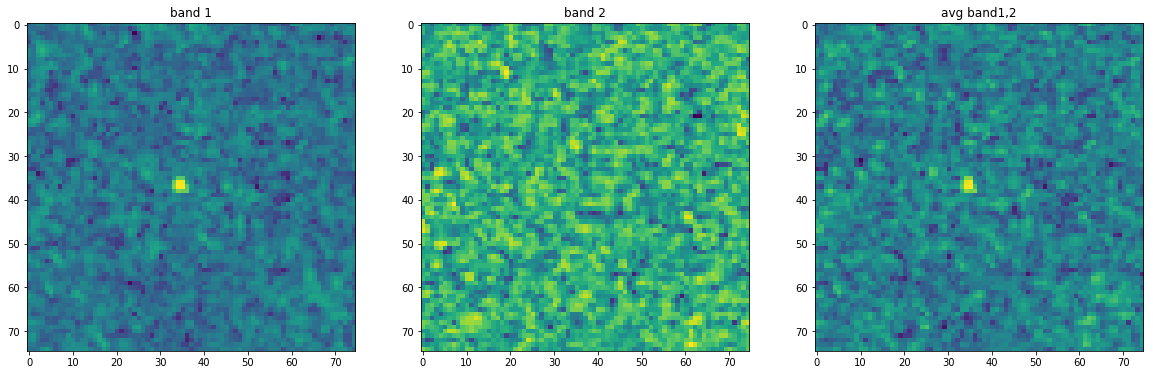

In [95]:
plot_img_set(img_num)

In [96]:
df_train[df_train['id']==valid_ids[img_num]]

,band_1,band_2,id,inc_angle,is_iceberg
1185,"[-25.880335, -23.764301, -22.872700000000002, ...","[-31.045895, -31.60651, -34.300526, -31.046021...",601cdc58,43.3577,0


In [97]:
data = df_train[df_train['id']==valid_ids[img_num]]

In [98]:
imgs =[]
for i, row in data.iterrows():
        #make 75x75 image
    band_1 = np.array(row['band_1']).reshape(75, 75)
    band_2 = np.array(row['band_2']).reshape(75, 75)
    band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)

    # Rescale
    a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
    b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
    c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

#         imgs.append(np.dstack((band_1, band_2, band_3)))
    imgs.append(np.dstack((a, b, c)))



(<matplotlib.image.AxesImage at 0x7f1e05b46898>,
 <matplotlib.text.Text at 0x7f1e05340ac8>)

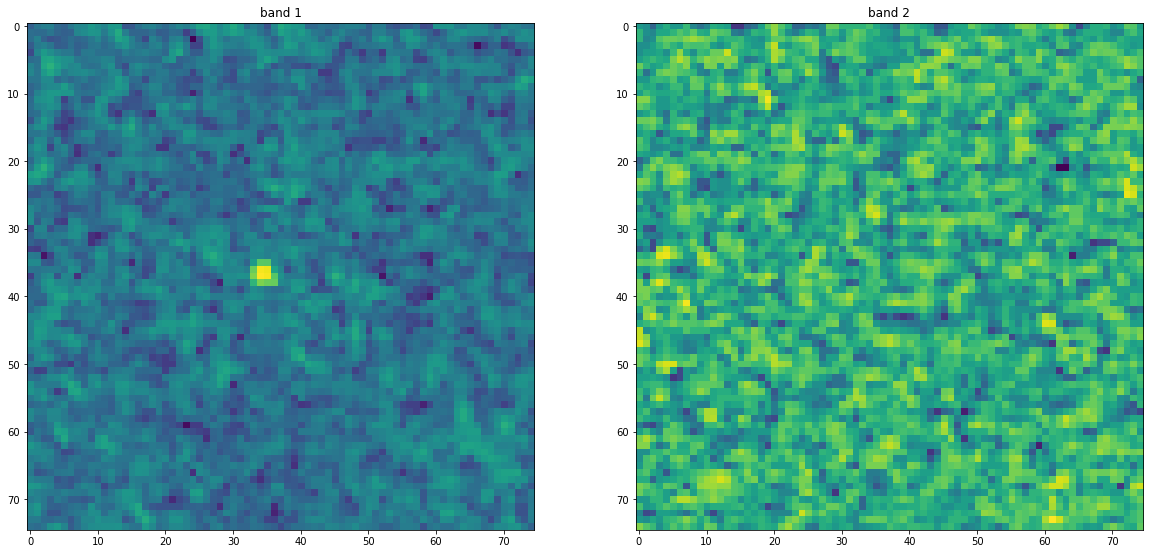

In [99]:
f,ax = plt.subplots(1,2,figsize=(20,10), squeeze=False)
ax[0][0].imshow(band_1), ax[0][0].set_title("band 1")
ax[0][1].imshow(band_2), ax[0][1].set_title("band 2")